## 预测房价


### 下载数据集


In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('.', 'data')):  
  """下载一个DATA_HUB中的文件，返回本地文件名。"""
  assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
      sha1 = hashlib.sha1()
      with open(fname, 'rb') as f:
          while True:
              data = f.read(1048576)
              if not data:
                  break
              sha1.update(data)
      if sha1.hexdigest() == sha1_hash:
          return fname  # Hit cache
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
      f.write(r.content)
  return fname

def download_extract(name, folder=None):  
  """下载并解压zip/tar文件。"""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
      fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
      fp = tarfile.open(fname, 'r')
  else:
      assert False, '只有zip/tar文件可以被解压缩。'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
  """下载DATA_HUB中的所有文件。"""
  for name in DATA_HUB:
      download(name)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[:4, [0, 1, 2, -3, -2, -1]])
print(test_data.iloc[:4, [0, 1, 2, -3, -2, -1]])

# 将id列从数据集中删除
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning SaleType SaleCondition  SalePrice
0   1          60       RL       WD        Normal     208500
1   2          20       RL       WD        Normal     181500
2   3          60       RL       WD        Normal     223500
3   4          70       RL       WD       Abnorml     140000
     Id  MSSubClass MSZoning  YrSold SaleType SaleCondition
0  1461          20       RH    2010       WD        Normal
1  1462          20       RL    2010       WD        Normal
2  1463          60       RL    2010       WD        Normal
3  1464          60       RL    2010       WD        Normal


### 数据预处理


In [ ]:
# 返回值为数值的所有列名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 对所有数值做归一化 normalization
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std()
)

all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features[numeric_features])

      MSSubClass  LotFrontage   LotArea  ...   MiscVal    MoSold    YrSold
0       0.067320    -0.184443 -0.217841  ... -0.089577 -1.551918  0.157619
1      -0.873466     0.458096 -0.072032  ... -0.089577 -0.446848 -0.602858
2       0.067320    -0.055935  0.137173  ... -0.089577  1.026577  0.157619
3       0.302516    -0.398622 -0.078371  ... -0.089577 -1.551918 -1.363335
4       0.067320     0.629439  0.518814  ... -0.089577  2.131647  0.157619
...          ...          ...       ...  ...       ...       ...       ...
1454    2.419286    -2.069222 -1.043758  ... -0.089577 -0.078492 -1.363335
1455    2.419286    -2.069222 -1.049083  ... -0.089577 -0.815205 -1.363335
1456   -0.873466     3.884968  1.246594  ... -0.089577  1.026577 -1.363335
1457    0.655311    -0.312950  0.034599  ...  1.144116  0.289865 -1.363335
1458    0.067320     0.201080 -0.068608  ... -0.089577  1.763290 -1.363335

[2919 rows x 36 columns]


接下来，我们处理离散值。这包括诸如“MSZoning”之类的特征。我们用一次独热编码替换它们，方法与前面将多类别标签转换为向量的方式相同。例如，“MSZoning”包含值“RL”和“Rm”。将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为 0 或 1。根据独热编码，如果“MSZoning”的原始值为“RL”，则:“MSZoning_RL”为 1，“MSZoning_RM”为 0。pandas 软件包会自动为我们实现这一点


In [ ]:
# ‘dummy_na’参数将缺失值“na”视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
# 特征数从79增加到了331个
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,-0.934542,-0.444176,-0.773728,1.207172,-0.10118,0.413476,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,0.986680,-0.924153,0.973110,0.306423,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,-0.629681,0.476948,0.261030,-0.784891,-0.10118,-0.471810,-0.819258,3.820454,0.781232,-0.756191,0.169898,-0.207663,-0.287709,0.623525,-0.082638,0.306423,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,-0.288418,-0.298974,-0.610614,1.235163,-0.10118,0.563659,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,-0.287709,0.623525,0.894907,0.306423,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,-0.047258,-0.671053,-0.506118,0.978574,-0.10118,0.427309,1.086464,-0.249767,-1.027187,-0.756191,0.169898,-0.207663,0.349486,0.623525,0.777601,1.619406,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,-0.161013,0.211501,-0.037164,1.671364,-0.10118,1.377806,1.086464,-0.249767,0.781232,1.232388,1.385418,-0.207663,1.623875,0.623525,0.855805,1.619406,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


通过 values 属性，从 pandas 对象中提取 numpy 格式，并将其转化为张量


In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(
    all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
  train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32
)

### 训练


对于房价，就像股票价格一样，我们关心的是相对数量，而不是绝对数量。因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]而不是绝对误差$y - \hat{y}$。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，我们的预测偏差了 10 万美元，在那里一栋典型的房子的价值是 12.5 万美元，那么我们可能做得很糟糕。另一方面，如果我们在加州豪宅区的预测出现了这个数字的偏差，这可能是一个惊人的准确预测（在那里，房价均值超过 400 万美元）。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。事实上，这也是比赛中官方用来评价提交质量的误差指标。即将 $\delta$ for $|\log y - \log \hat{y}| \leq \delta$转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

# todo 定义模型
model = nn.Sequential(nn.Linear(in_features, 1))
# model = nn.Sequential(nn.Linear(in_features, 24), nn.ReLU(), nn.Linear(24, 1))

def log_rmse(model, features, labels):
  # 为了在取对数时进一步稳定数值，将小于1的数值设为1
  clipped_pred = torch.clamp(model(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_pred), torch.log(labels)))
  return rmse.item()

In [ ]:
def train(model, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(model(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(model, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(model, test_features, test_labels))
    return train_ls, test_ls

### K 折交叉验证


函数在 𝐾 折交叉验证过程中返回第 𝑖 折的数据。它选择第 𝑖 个切片作为验证数据，其余部分作为训练数据


In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 在K折交叉验证中训练K次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    train_ls, valid_ls = train(model, *data, num_epochs, learning_rate, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log')
    print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
          f'valid log rmse {float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

### 调参


fold 1, train log rmse 0.127490, valid log rmse 0.166910
fold 2, train log rmse 0.116131, valid log rmse 0.175255
fold 3, train log rmse 0.113887, valid log rmse 0.161479
fold 4, train log rmse 0.118564, valid log rmse 0.161420
fold 5, train log rmse 0.109354, valid log rmse 0.176872
5-折验证: 平均训练log rmse: 0.117085, 平均验证log rmse: 0.168387


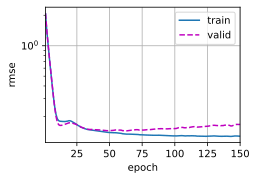

In [ ]:
# todo 调整参数
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 100, 0, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

### 提交预测文件


train log rmse 0.115460


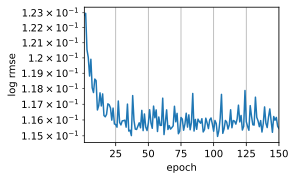

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    train_ls, _ = train(model, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = model(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)